In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
class UCF101Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        # Get all paths
        all_video_paths = glob(os.path.join(data_dir, '*', '*.avi'))

        # LIMIT TO FIRST 100 VIDEOS
        self.video_paths = all_video_paths[:100]

        self.transform = transform
        print(f"Total videos found: {len(all_video_paths)}")
        print(f"Using limited dataset: {len(self.video_paths)} videos.")

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        cap = cv2.VideoCapture(video_path)

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count == 0:
            cap.release()
            return self.__getitem__(random.randint(0, len(self) - 1))

        frame_idx = random.randint(0, frame_count - 1)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        ret, frame = cap.read()
        cap.release()

        if not ret:
            return self.__getitem__(random.randint(0, len(self) - 1))

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame)

        # --- Degradation ---
        degraded_np = cv2.GaussianBlur(frame, (7, 7), 0)
        h, w, _ = degraded_np.shape
        for _ in range(random.randint(3, 6)):
            ph, pw = random.randint(20, 60), random.randint(20, 60)
            px, py = random.randint(0, w - pw), random.randint(0, h - ph)

            # --- THIS IS THE FIX ---
            degraded_np[py:py+ph, px:px+pw, :] = 128 # Changed from 0 to 128
            # ---------------------

        noise = np.random.normal(0, 10, degraded_np.shape).astype(np.float32)
        degraded_np = np.clip(degraded_np.astype(np.float32) + noise, 0, 255).astype(np.uint8)

        degraded_pil = Image.fromarray(degraded_np)

        if self.transform:
            degraded_pil = self.transform(degraded_pil)
            frame_pil = self.transform(frame_pil)

        return degraded_pil, frame_pil

        # --- Degradation ---
        degraded_np = cv2.GaussianBlur(frame, (7, 7), 0)
        h, w, _ = degraded_np.shape
        for _ in range(random.randint(3, 6)):
            ph, pw = random.randint(20, 60), random.randint(20, 60)
            px, py = random.randint(0, w - pw), random.randint(0, h - ph)
            degraded_np[py:py+ph, px:px+pw, :] = 0

        noise = np.random.normal(0, 10, degraded_np.shape).astype(np.float32)
        degraded_np = np.clip(degraded_np.astype(np.float32) + noise, 0, 255).astype(np.uint8)

        degraded_pil = Image.fromarray(degraded_np)

        if self.transform:
            degraded_pil = self.transform(degraded_pil)
            frame_pil = self.transform(frame_pil)

        return degraded_pil, frame_pil

In [4]:
# PLEASE UPDATE THIS PATH to your actual dataset location if different
dataset_path = '/content/drive/MyDrive/UCF101/UCF-101'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 16

dataset = UCF101Dataset(data_dir=dataset_path, transform=transform)
# num_workers=0 might be safer if you encounter multiprocessing errors in Colab,
# but try 2 first for speed.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Total videos found: 13320
Using limited dataset: 100 videos.


In [5]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2))
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.enc3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.enc4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.enc5 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU())
        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.dec5 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.final_conv = nn.Sequential(nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        b = self.bottleneck(e5)
        d1 = self.dec1(b)
        d1 = torch.cat((d1, e5), dim=1)
        d2 = self.dec2(d1)
        d2 = torch.cat((d2, e4), dim=1)
        d3 = self.dec3(d2)
        d3 = torch.cat((d3, e3), dim=1)
        d4 = self.dec4(d3)
        d4 = torch.cat((d4, e2), dim=1)
        d5 = self.dec5(d4)
        d5 = torch.cat((d5, e1), dim=1)
        return self.final_conv(d5)

In [6]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2))
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.enc3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.enc4 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.enc5 = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        # Bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU())
        # Decoder
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(512, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU())
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU())
        self.dec4 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.dec5 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.final_conv = nn.Sequential(nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        b = self.bottleneck(e5)
        d1 = self.dec1(b)
        d1 = torch.cat((d1, e5), dim=1)
        d2 = self.dec2(d1)
        d2 = torch.cat((d2, e4), dim=1)
        d3 = self.dec3(d2)
        d3 = torch.cat((d3, e3), dim=1)
        d4 = self.dec4(d3)
        d4 = torch.cat((d4, e2), dim=1)
        d5 = self.dec5(d4)
        d5 = torch.cat((d5, e1), dim=1)
        return self.final_conv(d5)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 1, 1)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), dim=1)
        return self.model(img_input)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()
lambda_L1 = 100

In [9]:
num_epochs = 50 # UPDATED TO 50 EPOCHS

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    total_g_loss = 0
    total_d_loss = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for degraded_imgs, original_imgs in progress_bar:
        degraded_imgs = degraded_imgs.to(device)
        original_imgs = original_imgs.to(device)

        real_labels = torch.ones(degraded_imgs.size(0), 1, 14, 14, device=device)
        fake_labels = torch.zeros(degraded_imgs.size(0), 1, 14, 14, device=device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_output = discriminator(degraded_imgs, original_imgs)
        d_loss_real = criterion_GAN(real_output, real_labels)
        fake_imgs = generator(degraded_imgs)
        fake_output = discriminator(degraded_imgs, fake_imgs.detach())
        d_loss_fake = criterion_GAN(fake_output, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) * 0.5
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        optimizer_G.zero_grad()
        fake_output = discriminator(degraded_imgs, fake_imgs)
        g_loss_gan = criterion_GAN(fake_output, real_labels)
        g_loss_l1 = criterion_L1(fake_imgs, original_imgs) * lambda_L1
        g_loss = g_loss_gan + g_loss_l1
        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()
        progress_bar.set_postfix(G_loss=g_loss.item(), D_loss=d_loss.item())

    avg_g_loss = total_g_loss / len(dataloader)
    avg_d_loss = total_d_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Avg G_Loss: {avg_g_loss:.4f}, Avg D_Loss: {avg_d_loss:.4f}")

print("Training finished.")

Epoch 1/50: 100%|██████████| 7/7 [00:12<00:00,  1.84s/it, D_loss=0.707, G_loss=26.8]


Epoch 1/50 - Avg G_Loss: 38.4228, Avg D_Loss: 0.8830


Epoch 2/50: 100%|██████████| 7/7 [00:03<00:00,  2.30it/s, D_loss=0.725, G_loss=22.4]


Epoch 2/50 - Avg G_Loss: 24.0769, Avg D_Loss: 0.6576


Epoch 3/50: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s, D_loss=0.693, G_loss=15.4]


Epoch 3/50 - Avg G_Loss: 18.0066, Avg D_Loss: 0.6934


Epoch 4/50: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s, D_loss=0.633, G_loss=13]


Epoch 4/50 - Avg G_Loss: 15.9061, Avg D_Loss: 0.6653


Epoch 5/50: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s, D_loss=0.602, G_loss=14.9]


Epoch 5/50 - Avg G_Loss: 15.1984, Avg D_Loss: 0.5696


Epoch 6/50: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s, D_loss=0.418, G_loss=16.8]


Epoch 6/50 - Avg G_Loss: 14.5720, Avg D_Loss: 0.4959


Epoch 7/50: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s, D_loss=0.51, G_loss=16.3]


Epoch 7/50 - Avg G_Loss: 14.3710, Avg D_Loss: 0.4972


Epoch 8/50: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s, D_loss=0.19, G_loss=17.7]


Epoch 8/50 - Avg G_Loss: 15.1747, Avg D_Loss: 0.3563


Epoch 9/50: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s, D_loss=0.774, G_loss=13.3]


Epoch 9/50 - Avg G_Loss: 14.4965, Avg D_Loss: 0.4817


Epoch 10/50: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s, D_loss=0.514, G_loss=14.5]


Epoch 10/50 - Avg G_Loss: 13.9982, Avg D_Loss: 0.4943


Epoch 11/50: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s, D_loss=0.625, G_loss=13.4]


Epoch 11/50 - Avg G_Loss: 13.7484, Avg D_Loss: 0.6193


Epoch 12/50: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s, D_loss=0.551, G_loss=17.5]


Epoch 12/50 - Avg G_Loss: 13.7273, Avg D_Loss: 0.5579


Epoch 13/50: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s, D_loss=1.16, G_loss=13.8]


Epoch 13/50 - Avg G_Loss: 13.6450, Avg D_Loss: 0.6547


Epoch 14/50: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s, D_loss=0.551, G_loss=12.5]


Epoch 14/50 - Avg G_Loss: 13.2460, Avg D_Loss: 0.5339


Epoch 15/50: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, D_loss=0.698, G_loss=15.7]


Epoch 15/50 - Avg G_Loss: 12.5508, Avg D_Loss: 0.5271


Epoch 16/50: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s, D_loss=0.658, G_loss=12.8]


Epoch 16/50 - Avg G_Loss: 11.7933, Avg D_Loss: 0.6379


Epoch 17/50: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, D_loss=0.516, G_loss=13.2]


Epoch 17/50 - Avg G_Loss: 12.3755, Avg D_Loss: 0.5418


Epoch 18/50: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s, D_loss=0.481, G_loss=13.2]


Epoch 18/50 - Avg G_Loss: 11.5073, Avg D_Loss: 0.4875


Epoch 19/50: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s, D_loss=0.813, G_loss=11.3]


Epoch 19/50 - Avg G_Loss: 11.5764, Avg D_Loss: 0.5495


Epoch 20/50: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, D_loss=0.408, G_loss=12.3]


Epoch 20/50 - Avg G_Loss: 11.9068, Avg D_Loss: 0.4859


Epoch 21/50: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s, D_loss=0.83, G_loss=15.6]


Epoch 21/50 - Avg G_Loss: 12.3239, Avg D_Loss: 0.5880


Epoch 22/50: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s, D_loss=0.506, G_loss=18.3]


Epoch 22/50 - Avg G_Loss: 13.0049, Avg D_Loss: 0.5511


Epoch 23/50: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, D_loss=0.937, G_loss=10.8]


Epoch 23/50 - Avg G_Loss: 11.3562, Avg D_Loss: 0.6245


Epoch 24/50: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, D_loss=0.799, G_loss=14.2]


Epoch 24/50 - Avg G_Loss: 11.5564, Avg D_Loss: 0.5975


Epoch 25/50: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s, D_loss=0.567, G_loss=9.98]


Epoch 25/50 - Avg G_Loss: 10.6508, Avg D_Loss: 0.5184


Epoch 26/50: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s, D_loss=0.339, G_loss=11.6]


Epoch 26/50 - Avg G_Loss: 11.0764, Avg D_Loss: 0.4581


Epoch 27/50: 100%|██████████| 7/7 [00:02<00:00,  2.89it/s, D_loss=0.411, G_loss=17.9]


Epoch 27/50 - Avg G_Loss: 11.9109, Avg D_Loss: 0.4829


Epoch 28/50: 100%|██████████| 7/7 [00:02<00:00,  3.33it/s, D_loss=0.887, G_loss=12.9]


Epoch 28/50 - Avg G_Loss: 10.9967, Avg D_Loss: 0.8958


Epoch 29/50: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s, D_loss=0.611, G_loss=10.7]


Epoch 29/50 - Avg G_Loss: 10.8972, Avg D_Loss: 0.5847


Epoch 30/50: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s, D_loss=0.347, G_loss=13.7]


Epoch 30/50 - Avg G_Loss: 10.9256, Avg D_Loss: 0.5336


Epoch 31/50: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s, D_loss=0.459, G_loss=16.7]


Epoch 31/50 - Avg G_Loss: 11.1321, Avg D_Loss: 0.5416


Epoch 32/50: 100%|██████████| 7/7 [00:02<00:00,  2.49it/s, D_loss=0.823, G_loss=12.6]


Epoch 32/50 - Avg G_Loss: 11.6201, Avg D_Loss: 0.5610


Epoch 33/50: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s, D_loss=0.755, G_loss=12.6]


Epoch 33/50 - Avg G_Loss: 11.1505, Avg D_Loss: 0.6417


Epoch 34/50: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s, D_loss=0.513, G_loss=12.8]


Epoch 34/50 - Avg G_Loss: 11.3116, Avg D_Loss: 0.6187


Epoch 35/50: 100%|██████████| 7/7 [00:02<00:00,  3.38it/s, D_loss=0.421, G_loss=10.1]


Epoch 35/50 - Avg G_Loss: 10.5469, Avg D_Loss: 0.6562


Epoch 36/50: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s, D_loss=0.378, G_loss=13]


Epoch 36/50 - Avg G_Loss: 11.1105, Avg D_Loss: 0.5243


Epoch 37/50: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s, D_loss=0.34, G_loss=11.9]


Epoch 37/50 - Avg G_Loss: 10.2870, Avg D_Loss: 0.5506


Epoch 38/50: 100%|██████████| 7/7 [00:02<00:00,  2.65it/s, D_loss=0.533, G_loss=11.9]


Epoch 38/50 - Avg G_Loss: 10.7005, Avg D_Loss: 0.6252


Epoch 39/50: 100%|██████████| 7/7 [00:02<00:00,  2.67it/s, D_loss=0.447, G_loss=10.6]


Epoch 39/50 - Avg G_Loss: 10.2775, Avg D_Loss: 0.5987


Epoch 40/50: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, D_loss=0.983, G_loss=12.5]


Epoch 40/50 - Avg G_Loss: 11.0850, Avg D_Loss: 0.6755


Epoch 41/50: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s, D_loss=0.72, G_loss=18]


Epoch 41/50 - Avg G_Loss: 11.0652, Avg D_Loss: 0.6655


Epoch 42/50: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s, D_loss=0.579, G_loss=12.2]


Epoch 42/50 - Avg G_Loss: 10.6433, Avg D_Loss: 0.5621


Epoch 43/50: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s, D_loss=0.674, G_loss=10.9]


Epoch 43/50 - Avg G_Loss: 10.2526, Avg D_Loss: 0.5580


Epoch 44/50: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s, D_loss=0.598, G_loss=12.7]


Epoch 44/50 - Avg G_Loss: 10.3461, Avg D_Loss: 0.5522


Epoch 45/50: 100%|██████████| 7/7 [00:02<00:00,  2.50it/s, D_loss=0.587, G_loss=10.4]


Epoch 45/50 - Avg G_Loss: 9.8101, Avg D_Loss: 0.5465


Epoch 46/50: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s, D_loss=0.697, G_loss=11.9]


Epoch 46/50 - Avg G_Loss: 9.7754, Avg D_Loss: 0.5647


Epoch 47/50: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s, D_loss=0.714, G_loss=12.5]


Epoch 47/50 - Avg G_Loss: 9.9139, Avg D_Loss: 0.6127


Epoch 48/50: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s, D_loss=0.45, G_loss=10.9]


Epoch 48/50 - Avg G_Loss: 9.5145, Avg D_Loss: 0.5652


Epoch 49/50: 100%|██████████| 7/7 [00:02<00:00,  3.39it/s, D_loss=0.714, G_loss=12.2]


Epoch 49/50 - Avg G_Loss: 9.7916, Avg D_Loss: 0.6625


Epoch 50/50: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s, D_loss=0.542, G_loss=13]

Epoch 50/50 - Avg G_Loss: 9.7671, Avg D_Loss: 0.6273
Training finished.


In [10]:
def denorm(img_tensor):
    img = img_tensor.cpu().detach().squeeze(0) * 0.5 + 0.5
    img_np = np.transpose(img.numpy(), (1, 2, 0))
    return np.clip(img_np, 0, 1)

Visualizing results...


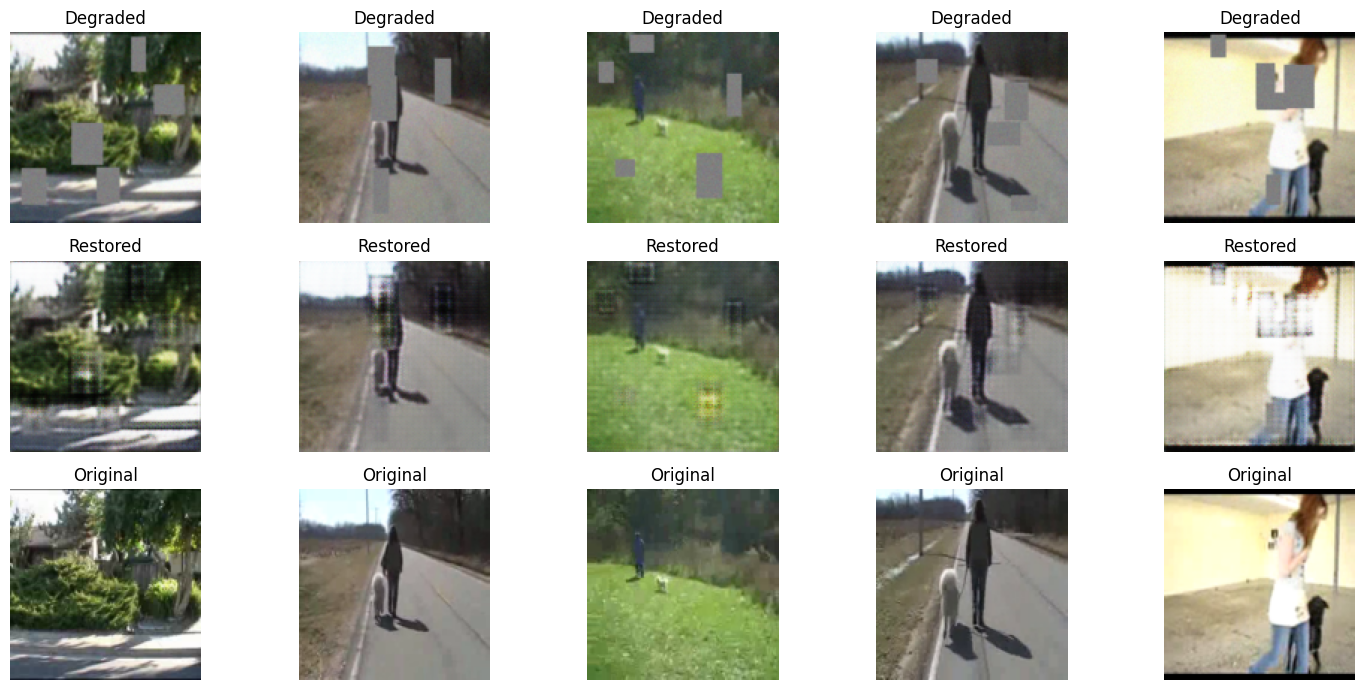

In [11]:
print("Visualizing results...")
generator.eval()

try:
    data_iter = iter(dataloader)
    degraded_batch, original_batch = next(data_iter)
except StopIteration:
    # Re-initialize if dataloader is exhausted
    data_iter = iter(dataloader)
    degraded_batch, original_batch = next(data_iter)

degraded_imgs = degraded_batch.to(device)
original_imgs = original_batch.to(device)

with torch.no_grad():
    restored_imgs = generator(degraded_imgs)

num_images = 5
plt.figure(figsize=(15, 7))
for i in range(min(num_images, len(degraded_imgs))):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(denorm(degraded_imgs[i]))
    plt.title("Degraded")
    plt.axis('off')

    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(denorm(restored_imgs[i]))
    plt.title("Restored")
    plt.axis('off')

    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(denorm(original_imgs[i]))
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
def degrade_frame(frame_rgb):
    """
    Applies the same degradation as the training dataset.
    Input: A single RGB frame (NumPy array, HxWxC, 0-255).
    Output: A degraded RGB frame (NumPy array, HxWxC, 0-255).
    """
    degraded_np = cv2.GaussianBlur(frame_rgb, (7, 7), 0)
    h, w, _ = degraded_np.shape

    # Add random grey patches
    for _ in range(random.randint(3, 6)):
        ph, pw = random.randint(20, 60), random.randint(20, 60)
        px, py = random.randint(0, w - pw), random.randint(0, h - ph)

        # --- THIS IS THE FIX ---
        degraded_np[py:py+ph, px:px+pw, :] = 128 # Changed from 0 to 128
        # ---------------------

    # Add noise
    noise = np.random.normal(0, 10, degraded_np.shape).astype(np.float32)
    degraded_np = np.clip(degraded_np.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    return degraded_np

Displaying 10 random samples from the dataloader...


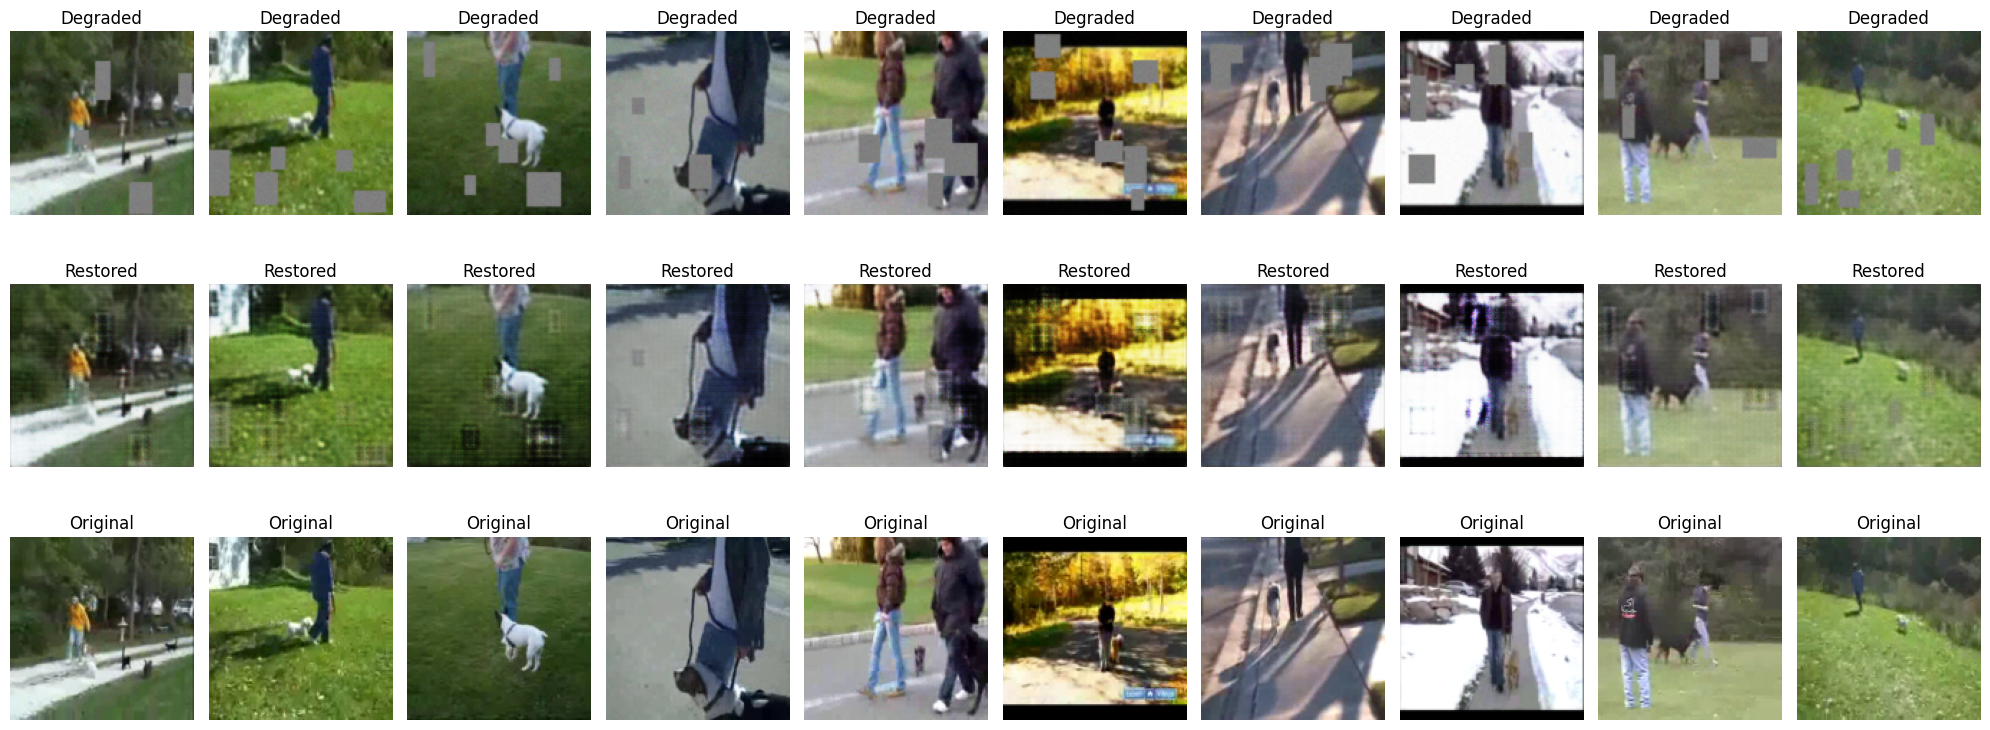

In [13]:
print("Displaying 10 random samples from the dataloader...")
generator.eval()

# Get a batch of data
try:
    data_iter = iter(dataloader)
    degraded_batch, original_batch = next(data_iter)
except StopIteration:
    data_iter = iter(dataloader)
    degraded_batch, original_batch = next(data_iter)
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure your dataloader and dataset path (Cell 3) are correct.")

# Ensure we have at least 10 images
if len(degraded_batch) < 10:
    print(f"Batch size is {len(degraded_batch)}, displaying that many.")
    num_images = len(degraded_batch)
else:
    num_images = 10

# Move to device and generate
degraded_imgs = degraded_batch.to(device)
original_imgs = original_batch.to(device)

with torch.no_grad():
    restored_imgs = generator(degraded_imgs)

# Plot
plt.figure(figsize=(20, 8))
for i in range(num_images):
    # Degraded Image
    plt.subplot(3, num_images, i + 1)
    plt.imshow(denorm(degraded_imgs[i]))
    plt.title("Degraded")
    plt.axis('off')

    # Restored Image
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(denorm(restored_imgs[i]))
    plt.title("Restored")
    plt.axis('off')

    # Original Image
    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(denorm(original_imgs[i]))
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()

Displaying 10 frames from a single video...
Processing video: v_WalkingWithDog_g15_c02.avi


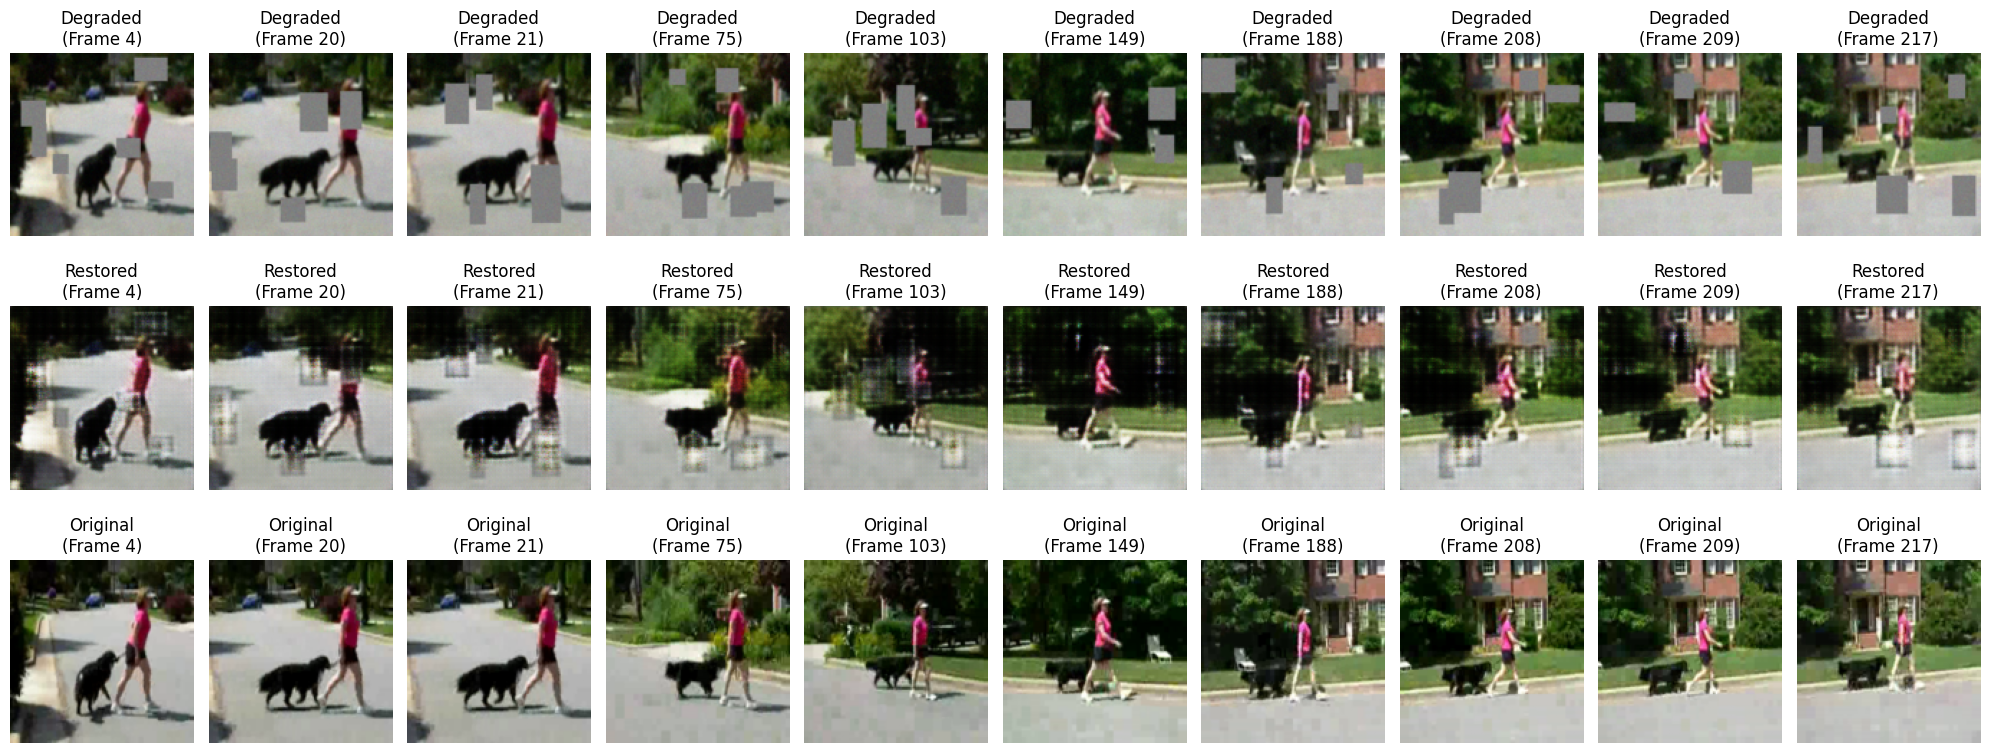

In [14]:
print("Displaying 10 frames from a single video...")
generator.eval()

# Pick one random video from the dataset
video_path = random.choice(dataset.video_paths)
print(f"Processing video: {os.path.basename(video_path)}")

cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Select 10 random frame indices
if frame_count > 10:
    frame_indices = sorted(random.sample(range(frame_count), 10))
else:
    frame_indices = list(range(frame_count))

original_frames_to_plot = []
degraded_frames_to_plot = []
restored_frames_to_plot = []

with torch.no_grad():
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        # 1. Original
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        original_pil = Image.fromarray(frame_rgb)
        original_tensor = transform(original_pil).to(device)
        original_frames_to_plot.append(original_tensor)

        # 2. Degraded
        degraded_np = degrade_frame(frame_rgb)
        degraded_pil = Image.fromarray(degraded_np)
        degraded_tensor = transform(degraded_pil).to(device)
        degraded_frames_to_plot.append(degraded_tensor)

        # 3. Restored
        restored_tensor = generator(degraded_tensor.unsqueeze(0)) # Add batch dim
        restored_frames_to_plot.append(restored_tensor.squeeze(0)) # Remove batch dim

cap.release()

# Plot the 10 frames
num_images = len(original_frames_to_plot)
if num_images > 0:
    plt.figure(figsize=(20, 8))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(denorm(degraded_frames_to_plot[i]))
        plt.title(f"Degraded\n(Frame {frame_indices[i]})")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(denorm(restored_frames_to_plot[i]))
        plt.title(f"Restored\n(Frame {frame_indices[i]})")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(denorm(original_frames_to_plot[i]))
        plt.title(f"Original\n(Frame {frame_indices[i]})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Could not read frames from the selected video.")

In [15]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    """
    Calculates the PSNR between two images.
    Images are expected to be NumPy arrays with pixel values in the range [0, 255].
    """
    # Convert to float64 for precision during calculations
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # Calculate Mean Squared Error
    mse = np.mean((img1 - img2) ** 2)

    # If MSE is 0, the images are identical, PSNR is infinite
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))

    return psnr

Please enter the full path to the ORIGINAL video: /content/drive/MyDrive/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
Please enter the full path to the DEGRADED video: /content/drive/MyDrive/UCF101/UCF-101/ApplyEyeMakeup/degraded_videos/v_ApplyEyeMakeup_g01_c01.avi
Loading Original Video: /content/drive/MyDrive/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
Loading Degraded Video: /content/drive/MyDrive/UCF101/UCF-101/ApplyEyeMakeup/degraded_videos/v_ApplyEyeMakeup_g01_c01.avi
Will save restored video to: /content/drive/MyDrive/output_vid/v_ApplyEyeMakeup_g01_c01_restored.avi
Processed frame 50/164 (Current PSNR: 22.98 dB)
Processed frame 100/164 (Current PSNR: 22.80 dB)
Processed frame 150/164 (Current PSNR: 22.67 dB)

--- Video saved successfully to /content/drive/MyDrive/output_vid/v_ApplyEyeMakeup_g01_c01_restored.avi ---
--- Average PSNR for the video: 22.70 dB ---

Displaying 10 sample frames from the video...


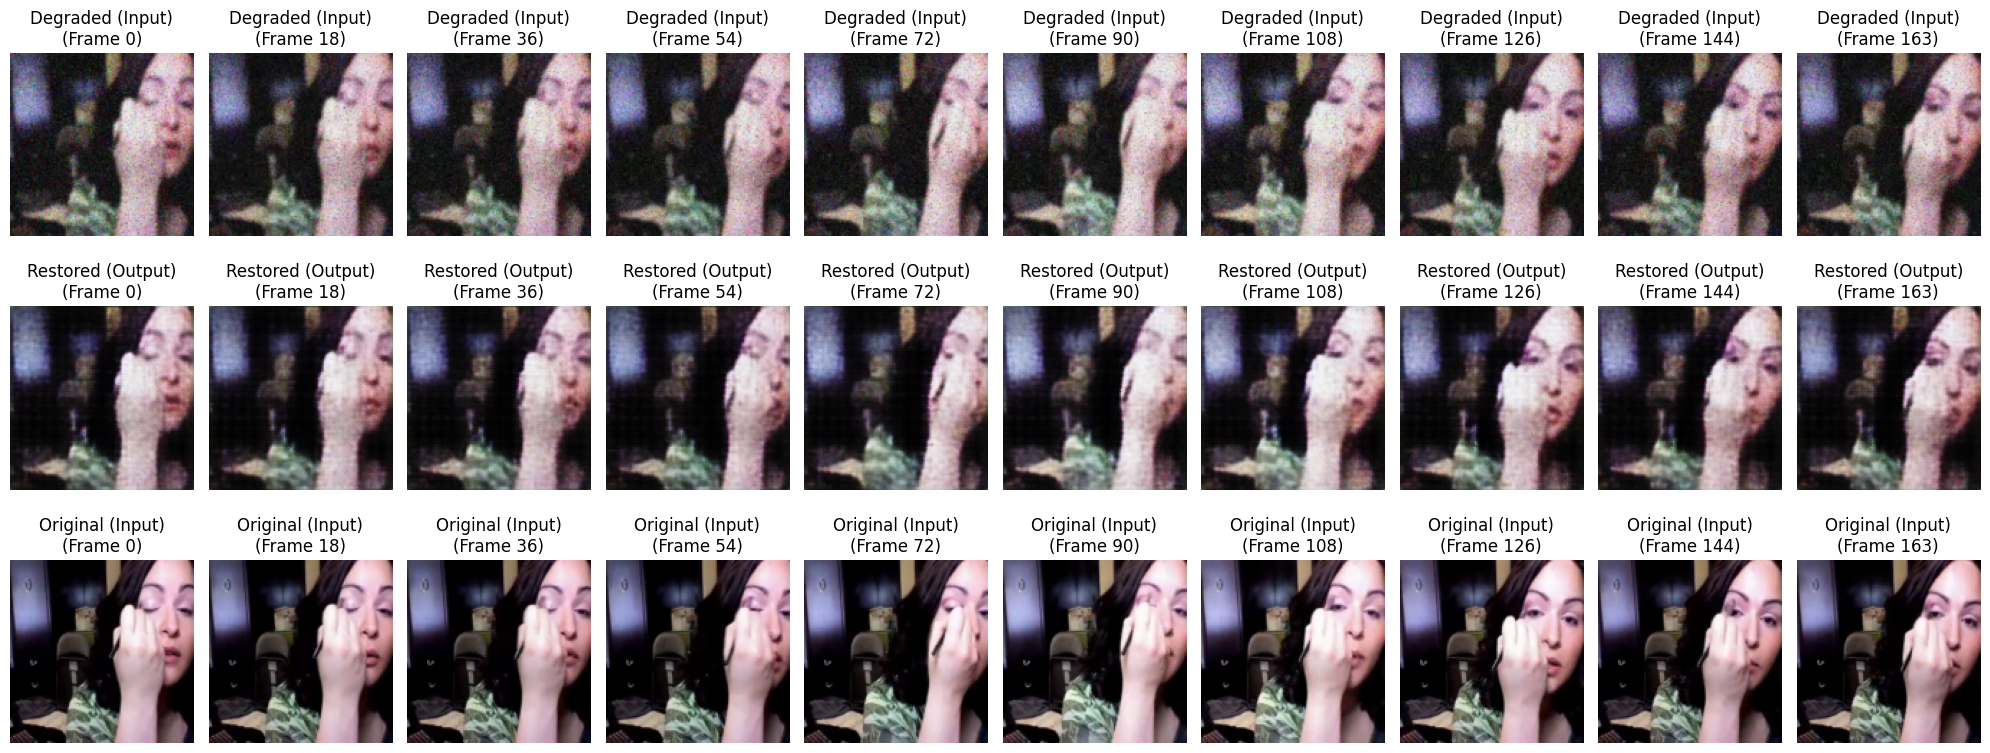

In [16]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# --- 1. USER INPUT ---
ORIGINAL_VIDEO_PATH = input("Please enter the full path to the ORIGINAL video: ")
DEGRADED_VIDEO_PATH = input("Please enter the full path to the DEGRADED video: ")

# --- 2. DEFINE OUTPUT PATH ---
OUTPUT_FOLDER = "/content/drive/MyDrive/output_vid"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

base_name = os.path.basename(DEGRADED_VIDEO_PATH)
file_name_without_ext = os.path.splitext(base_name)[0]
output_filename = f"{file_name_without_ext}_restored.avi"
OUTPUT_VIDEO_PATH = os.path.join(OUTPUT_FOLDER, output_filename)

# --- 3. CHECK IF FILES EXIST ---
if not os.path.exists(ORIGINAL_VIDEO_PATH):
    print(f"Error: Cannot find original video at path: {ORIGINAL_VIDEO_PATH}")
elif not os.path.exists(DEGRADED_VIDEO_PATH):
    print(f"Error: Cannot find degraded video at path: {DEGRADED_VIDEO_PATH}")
else:
    print(f"Loading Original Video: {ORIGINAL_VIDEO_PATH}")
    print(f"Loading Degraded Video: {DEGRADED_VIDEO_PATH}")
    print(f"Will save restored video to: {OUTPUT_VIDEO_PATH}")

    generator.eval()
    cap_orig = cv2.VideoCapture(ORIGINAL_VIDEO_PATH)
    cap_deg = cv2.VideoCapture(DEGRADED_VIDEO_PATH)

    fps = cap_orig.get(cv2.CAP_PROP_FPS)
    frame_count_orig = int(cap_orig.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count_deg = int(cap_deg.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count_orig != frame_count_deg:
        print(f"Warning: Videos have different frame counts! (Orig: {frame_count_orig}, Deg: {frame_count_deg})")

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (128, 128))

    frames_to_plot = []
    plot_indices = np.linspace(0, min(frame_count_orig, frame_count_deg) - 1, 10, dtype=int)

    psnr_values = [] # <-- List to store PSNR for each frame
    current_frame = 0

    with torch.no_grad():
        while(cap_orig.isOpened() and cap_deg.isOpened()):
            ret_orig, frame_orig = cap_orig.read()
            ret_deg, frame_deg = cap_deg.read()

            if not ret_orig or not ret_deg:
                break

            # --- Pre-processing (from DEGRADED frame) ---
            frame_deg_rgb = cv2.cvtColor(frame_deg, cv2.COLOR_BGR2RGB)
            degraded_pil = Image.fromarray(frame_deg_rgb)
            degraded_tensor = transform(degraded_pil).to(device).unsqueeze(0)

            # --- Model Inference ---
            restored_tensor = generator(degraded_tensor)

            # --- Post-processing for Saving ---
            restored_np_0_1 = denorm(restored_tensor)
            restored_np_0_255 = (restored_np_0_1 * 255).astype(np.uint8)
            restored_bgr = cv2.cvtColor(restored_np_0_255, cv2.COLOR_RGB2BGR)

            out.write(restored_bgr)

            # --- PSNR CALCULATION ---
            # We need the original frame resized to 128x128 for a
            # fair comparison with the 128x128 restored output.
            frame_orig_rgb = cv2.cvtColor(frame_orig, cv2.COLOR_BGR2RGB)
            original_pil = Image.fromarray(frame_orig_rgb)
            original_tensor = transform(original_pil).to(device)

            # Convert original tensor to 0-255 numpy array
            original_np_0_1 = denorm(original_tensor)
            original_np_0_255 = (original_np_0_1 * 255).astype(np.uint8)

            # Calculate PSNR between 128x128 original and 128x128 restored
            psnr = calculate_psnr(original_np_0_255, restored_np_0_255)
            psnr_values.append(psnr)
            # ---

            # --- Store frames for plotting ---
            if current_frame in plot_indices:
                frames_to_plot.append((degraded_tensor.squeeze(0),
                                       restored_tensor.squeeze(0),
                                       original_tensor))

            current_frame += 1
            if current_frame % 50 == 0:
                print(f"Processed frame {current_frame}/{frame_count_orig} (Current PSNR: {psnr:.2f} dB)")

    cap_orig.release()
    cap_deg.release()
    out.release()

    # --- FINAL EVALUATION ---
    print(f"\n--- Video saved successfully to {OUTPUT_VIDEO_PATH} ---")
    if psnr_values:
        avg_psnr = np.mean(psnr_values)
        print(f"--- Average PSNR for the video: {avg_psnr:.2f} dB ---")
    else:
        print("--- No frames were processed, cannot calculate PSNR. ---")

    # --- Display the 10 sample frames ---
    print("\nDisplaying 10 sample frames from the video...")
    num_images = len(frames_to_plot)
    if num_images > 0:
        plt.figure(figsize=(20, 8))
        for i in range(num_images):
            deg, res, orig = frames_to_plot[i]

            plt.subplot(3, num_images, i + 1 + 2 * num_images)
            plt.imshow(denorm(orig))
            plt.title(f"Original (Input)\n(Frame {plot_indices[i]})")
            plt.axis('off')

            plt.subplot(3, num_images, i + 1)
            plt.imshow(denorm(deg))
            plt.title(f"Degraded (Input)\n(Frame {plot_indices[i]})")
            plt.axis('off')

            plt.subplot(3, num_images, i + 1 + num_images)
            plt.imshow(denorm(res))
            plt.title(f"Restored (Output)\n(Frame {plot_indices[i]})")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
Objective: To test the trained model on a full, unseen degraded video.
Test File: v_ApplyEyeMakeup_g01_c01.avi (164 frames)
Metric: Peak Signal-to-Noise Ratio (PSNR), a standard metric for measuring image restoration quality (higher is better).
Process:
Loaded the degraded video.
Processed all 164 frames individually through the U-Net Generator.
Saved the new, "restored" video.
Quantitative Result
Achieved an Average PSNR of 22.70 dB across the entire video.
Visual Reference: The notebook output displays 10 sample frames, allowing for a side-by-side comparison of the restored video